**Import libraries and data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

directories = ['../input/100-bird-species/birds_rev2/test',
                                '../input/100-bird-species/birds_rev2/train',
                                '../input/100-bird-species/birds_rev2/valid']
for dir in directories:
    label = []
    path = []
    for dirname, _,filenames in os.walk(dir):
        for filename in filenames:
            label.append(os.path.split(dirname)[1])
            path.append(os.path.join(dirname,filename))
    if dir == directories[0]:
        df_test = pd.DataFrame(columns=['path','label'])
        df_test['path']=path
        df_test['label']=label
    elif dir == directories[1]:
        df_train = pd.DataFrame(columns=['path','label'])
        df_train['path']=path
        df_train['label']=label        
    elif dir == directories[2]:
        df_valid = pd.DataFrame(columns=['path','label'])
        df_valid['path']=path
        df_valid['label']=label

# EDA

In [3]:
df_train.head()

,path,label
0,../input/100-bird-species/birds_rev2/train/WAT...,WATTLED CURASSOW
1,../input/100-bird-species/birds_rev2/train/WAT...,WATTLED CURASSOW
2,../input/100-bird-species/birds_rev2/train/WAT...,WATTLED CURASSOW
3,../input/100-bird-species/birds_rev2/train/WAT...,WATTLED CURASSOW
4,../input/100-bird-species/birds_rev2/train/WAT...,WATTLED CURASSOW


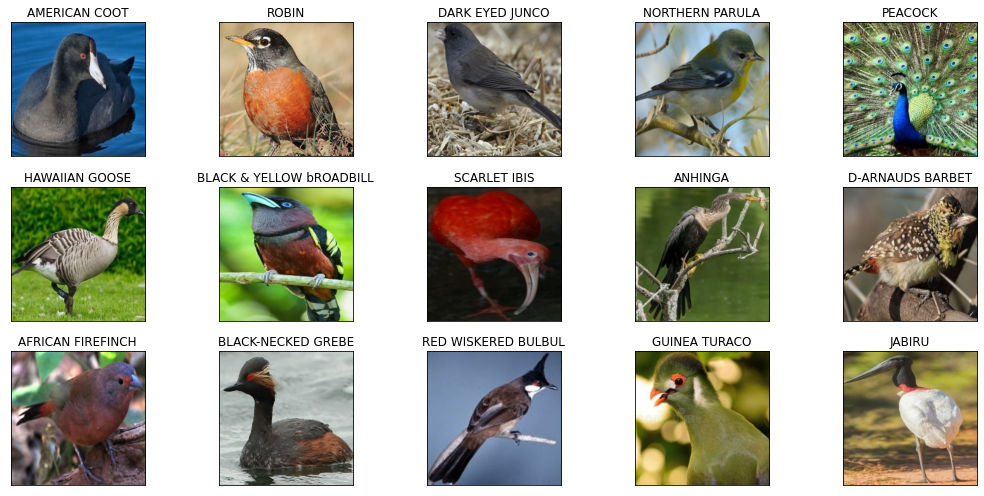

In [4]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

df_sample = df_train.sample(15)
df_sample.reset_index(drop=True, inplace=True)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_sample.path[i]))
    ax.set_title(df_sample.label[i])
plt.tight_layout()
plt.show()

# Neural Network with Transfer Learning

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

In [6]:
image_size = (224,224)
image_shape=(224,224,3)

**Baseline**

Found 39364 validated image filenames belonging to 275 classes.
Found 1375 validated image filenames belonging to 275 classes.
Found 1375 validated image filenames belonging to 275 classes.


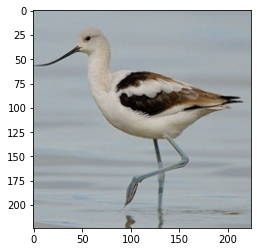

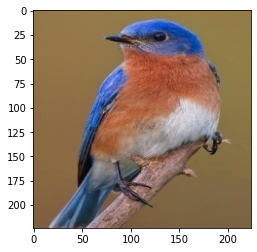

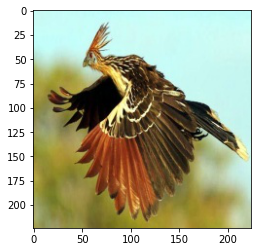

In [7]:
BS = 32

train_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = df_valid, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

test_generator = valid_datagen.flow_from_dataframe(
    dataframe = df_test, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False)

for _ in range(3):
    img, label = train_generator.next()
    plt.imshow(img[0])
    plt.show()

219062272/219055592 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 275)               10560275  
Total params: 64,897,011
Trainable params: 10,560,275
Non-trainable params: 54,336,736
_________________________________________________________________
Epoch 1/25
1231/1231 [==============================] - 309s 239ms/step - loss: 20.4411 - accuracy: 0.4292 - val_loss: 9.7031 - val_accuracy: 0.7229
Epoch 2/25
1231/1231 [==============================] - 143s 116ms/step - loss: 7.0345 - accuracy: 0.7826 - val_loss: 9.1955 - val_accuracy: 0.7884
E

Text(0.5, 1.0, 'Loss')

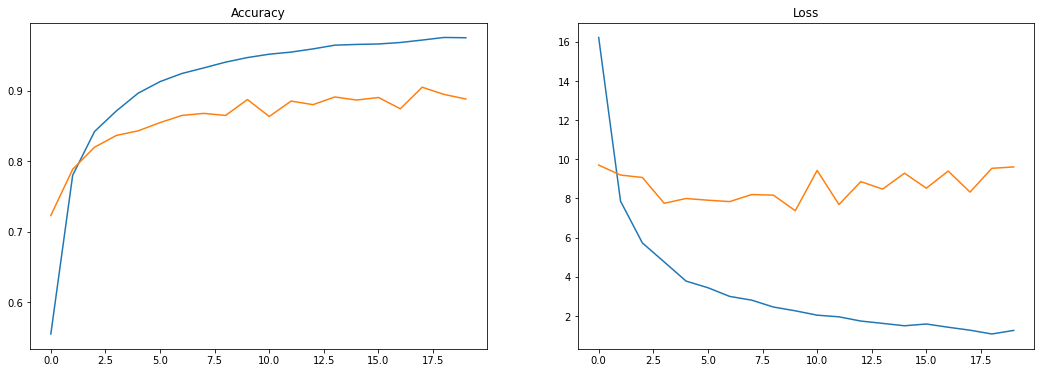

In [8]:
#model

resnet_model=tf.keras.applications.InceptionResNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
resnet_model.trainable = False


baseline_model = keras.Sequential([  
    resnet_model,
    layers.Flatten(),
    layers.Dense(units=275, activation="softmax"),
])
baseline_model.summary()

baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#fit

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=10)

history = baseline_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=25,
    verbose=1,
    callbacks=[early_stop]
)

result=pd.DataFrame(history.history)
fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax=ax.flatten()
ax[0].plot(result[['accuracy','val_accuracy']])
ax[0].set_title("Accuracy")
ax[1].plot(result[['loss','val_loss']])
ax[1].set_title("Loss")

In [9]:
baseline_model.evaluate(test_generator,use_multiprocessing=True,workers=10)

43/43 [==============================] - 7s 143ms/step - loss: 8.3979 - accuracy: 0.8996


[8.39786148071289, 0.8996363878250122]

**Decreasing overfitting with image augmentation**

Found 39364 validated image filenames belonging to 275 classes.
Found 1375 validated image filenames belonging to 275 classes.
Found 1375 validated image filenames belonging to 275 classes.


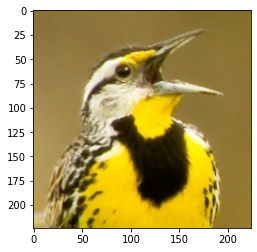

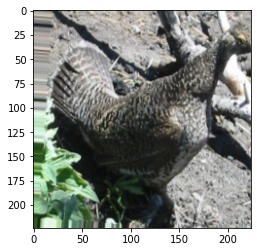

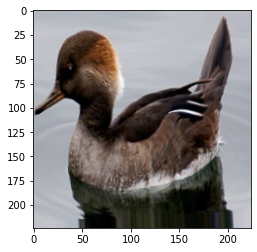

In [10]:
BS = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = df_valid, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

test_generator = valid_datagen.flow_from_dataframe(
    dataframe = df_test, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

for _ in range(3):
    img, label = train_generator.next()
    plt.imshow(img[0])
    plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 275)               10560275  
Total params: 64,897,011
Trainable params: 10,560,275
Non-trainable params: 54,336,736
_________________________________________________________________
Epoch 1/25
1231/1231 [==============================] - 496s 396ms/step - loss: 21.1629 - accuracy: 0.4161 - val_loss: 8.4102 - val_accuracy: 0.7425
Epoch 2/25
1231/1231 [==============================] - 484s 393ms/step - loss: 11.0705 - accuracy: 0.7150 - val_loss: 7.2521 - val_accuracy: 0.7971
Epoch 3/25
1231/1231 [==============================] - 484s 393m

Text(0.5, 1.0, 'Loss')

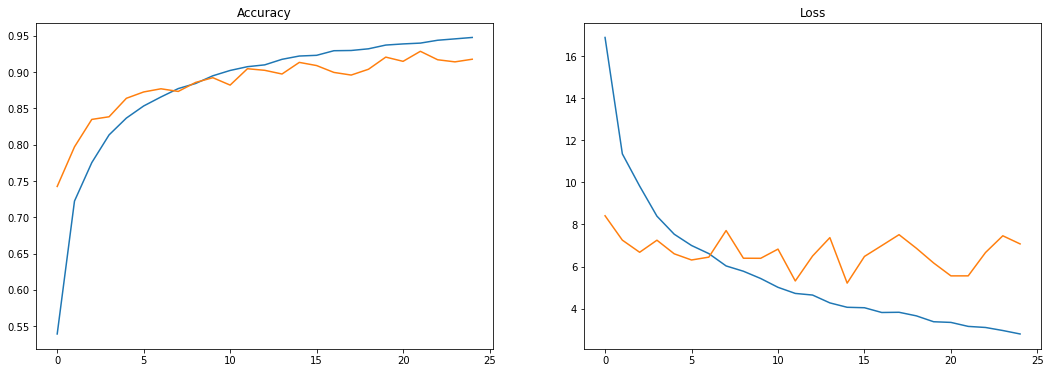

In [11]:
#model

resnet_model=tf.keras.applications.InceptionResNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
resnet_model.trainable = False


aug_model = keras.Sequential([  
    resnet_model,
    layers.Flatten(),
    layers.Dense(units=275, activation="softmax"),
])
aug_model.summary()

aug_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#fit

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=10)

history = aug_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=25,
    verbose=1,
    callbacks=[early_stop]
)

result=pd.DataFrame(history.history)
fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax=ax.flatten()
ax[0].plot(result[['accuracy','val_accuracy']])
ax[0].set_title("Accuracy")
ax[1].plot(result[['loss','val_loss']])
ax[1].set_title("Loss")

In [12]:
aug_model.evaluate(test_generator,use_multiprocessing=True,workers=10)

43/43 [==============================] - 8s 149ms/step - loss: 6.4385 - accuracy: 0.9178


[6.438529014587402, 0.9178181886672974]

**Improving the neural network with additional layers**

Found 39364 validated image filenames belonging to 275 classes.
Found 1375 validated image filenames belonging to 275 classes.
Found 1375 validated image filenames belonging to 275 classes.


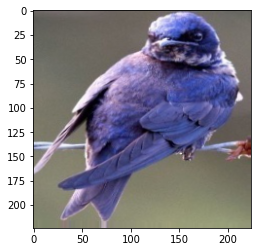

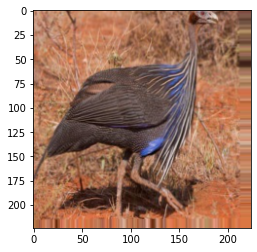

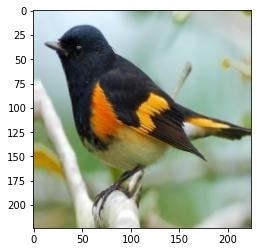

In [13]:
BS = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = df_valid, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

test_generator = valid_datagen.flow_from_dataframe(
    dataframe = df_test, x_col='path', y_col='label',
    target_size= image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

for _ in range(3):
    img, label = train_generator.next()
    plt.imshow(img[0])
    plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1950)              74881950  
_________________________________________________________________
batch_normalization_609 (Bat (None, 1950)              7800      
_________________________________________________________________
dense_3 (Dense)              (None, 275)               536525    
Total params: 129,763,011
Trainable params: 75,422,375
Non-trainable params: 54,340,636
_________________________________________________________________
Epoch 1/25
1231/1231 [==============================] - 499s 397ms/step - loss: 2.4699 - accuracy:

Text(0.5, 1.0, 'Loss')

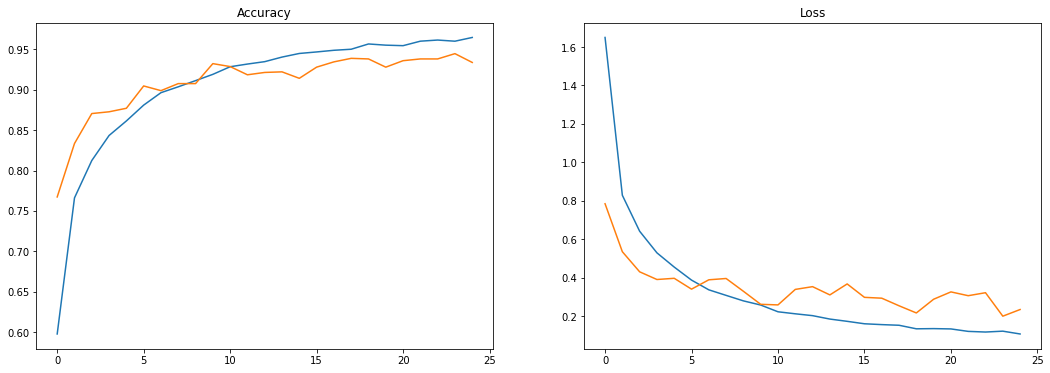

In [14]:
#model

resnet_model=tf.keras.applications.InceptionResNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')
resnet_model.trainable = False


layers_model = keras.Sequential([  
    resnet_model,
    layers.Flatten(),
    layers.Dense(units=1950,activation='relu'),
    layers.BatchNormalization(),
#     layers.Dropout(.3),
    layers.Dense(units=275, activation="softmax"),
])
layers_model.summary()

layers_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#fit

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=10)

history = layers_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=25,
    verbose=1,
    callbacks=[early_stop]
)

result=pd.DataFrame(history.history)
fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax=ax.flatten()
ax[0].plot(result[['accuracy','val_accuracy']])
ax[0].set_title("Accuracy")
ax[1].plot(result[['loss','val_loss']])
ax[1].set_title("Loss")

In [15]:
layers_model.evaluate(test_generator,use_multiprocessing=True,workers=10)

43/43 [==============================] - 8s 140ms/step - loss: 0.1927 - accuracy: 0.9462


[0.1927439421415329, 0.9461818337440491]